In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats as sps
from scipy.interpolate import interp1d
import re
from imp import reload
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 50)


Bad key "axes.titlelocation" on line 298 in
D:\Documents\work stuff\COVID\AFIT git\Updated Rt\matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [11]:
sps.poisson.pmf(3.6, 3)

0.0

In [2]:
# url = 'https://covidtracking.com/api/v1/states/daily.csv'
# states = pd.read_csv(url,
#                      usecols=['date', 'state', 'positive'],
#                      parse_dates=['date'],
#                      index_col=['state', 'date'],
#                      squeeze=True).sort_index()

In [26]:
import realtime_rt as rt
reload(rt)

<module 'realtime_rt' from 'D:\\Documents\\work stuff\\COVID\\AFIT git\\Updated Rt\\realtime_rt.py'>

In [19]:
county_data = rt.get_data()
county_data

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,...,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29
CountyFIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12,12,12,12,15,17,19,19,19,23,24,26,26,25,26,28,30,32,33,36,36,37,39,40,43
1003.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,29,38,42,44,56,59,66,71,72,87,91,101,103,109,112,117,123,132,143,147,147,161,168,171,174
1005.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,3,3,4,9,9,10,10,11,12,14,15,18,20,22,28,29,30,32,32,33,35,37,37
1007.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5,7,8,9,9,11,13,16,17,17,18,22,24,26,28,32,32,34,33,34,34,38,42,42,42
1009.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,11,12,12,13,14,16,17,18,20,20,21,22,26,29,31,31,31,34,34,34,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56039.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,39,40,41,44,45,50,53,56,56,57,58,59,61,62,62,62,92,93,93,95,95,95,95,96,96
56041.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,3,3,3,4,4,4,4,4,4,4,6,6,6,6,7,7,7,7,7,7,7,8,8
56043.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,5,5,5,5,5,5,5,5,6,5,5,5,5,8,8,8,8,8,8,8,8,8


In [56]:
smoothed_data = county_data.apply(rt.smooth_cases, axis=1, return_original=False, cutoff=4)
smoothed_data = smoothed_data.dropna(how='all', axis='rows')
smoothed_data


,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,...,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29
CountyFIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1003.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
1013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,5.0,5.0
1015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0
1017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,12.0,13.0,13.0,13.0,13.0,12.0,12.0,12.0,11.0,10.0,9.0,8.0,7.0,7.0,6.0,6.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,3.0
1031.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,11.0,12.0,12.0,12.0,12.0
55127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,4.0,5.0,5.0,5.0,6.0,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,8.0,8.0,8.0
55133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,5.0,6.0,7.0,...,9.0,9.0,9.0,9.0,9.0,9.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0,7.0,7.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,7.0,7.0,7.0


In [57]:
posterior_distr = smoothed_data.apply(rt.get_posteriors, axis=1)

In [22]:
latest_rts = posterior_distr.apply(lambda x: rt.highest_density_interval(x.iloc[:,-1]))

In [24]:
latest_rts.describe()

,Low_90,Best_Guess,High_90
count,952.000000,952.000000,952.000000
mean,0.071218,0.821145,2.277563
std,0.160121,0.333927,1.087609
min,0.000000,0.000000,0.510000
25%,0.000000,0.560000,1.830000
50%,0.000000,0.730000,2.120000
75%,0.040000,1.030000,2.390000
max,1.020000,2.270000,10.810000


In [58]:
all_rts = posterior_distr.apply(rt.highest_density_interval, just_best=True)

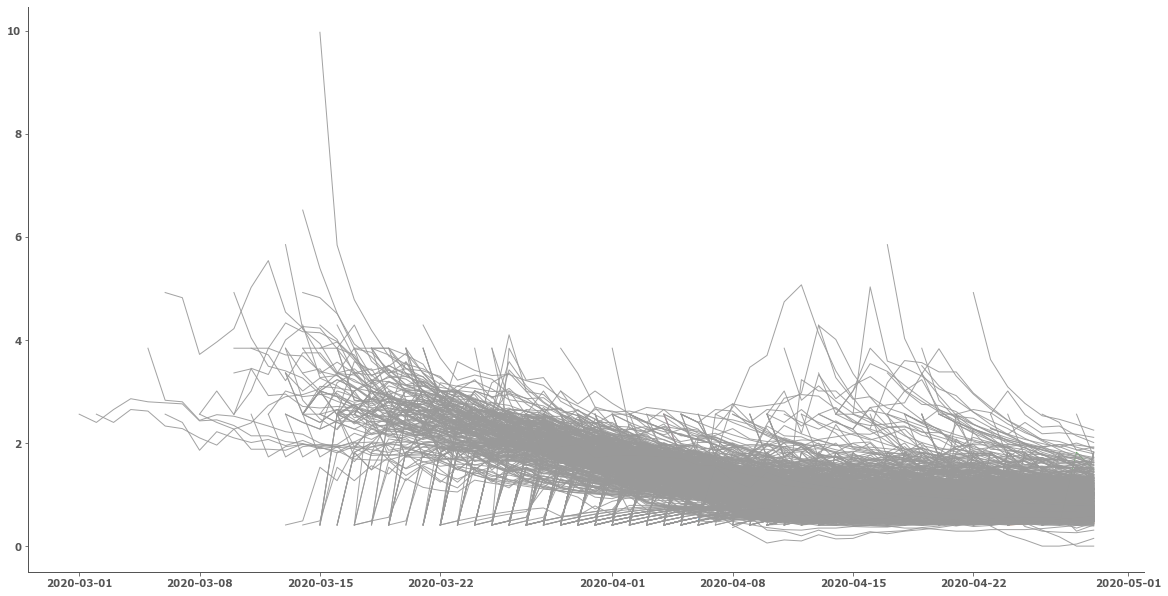

In [59]:
fig, ax = plt.subplots(figsize=(20, 10))
palette = plt.get_cmap('Set1')
num=0
for county in all_rts:
    num+=1
    ax.plot(county.index[1:], county[0][1:], marker='', color=palette(num), linewidth=1, alpha=0.9)


In [40]:
all_rts.iloc[0].index

DatetimeIndex(['2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07',
               '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11',
               '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
               '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27',
               '2020-04-28', '2020-04-29'],
              dtype='datetime64[ns]', freq=None)

In [26]:
latest_rts.to_csv(f'Estimated R_t by county for {smoothed_data.columns[-1].year}{smoothed_data.columns[-1].month:2}{smoothed_data.columns[-1].day:2}.csv')

In [6]:
for i, row in posterior_distr.iteritems():
    fips = i
    latest_rt = rt.highest_density_interval(row.iloc[:,-1])

In [69]:
smoothed_data.loc[fips]

2020-03-02    NaN
2020-03-03    NaN
2020-03-04    NaN
2020-03-05    NaN
2020-03-06    NaN
2020-03-07    NaN
2020-03-08    NaN
2020-03-09    NaN
2020-03-10    NaN
2020-03-11    NaN
2020-03-12    NaN
2020-03-13    NaN
2020-03-14    NaN
2020-03-15    NaN
2020-03-16    NaN
2020-03-17    NaN
2020-03-18    NaN
2020-03-19    NaN
2020-03-20    NaN
2020-03-21    NaN
2020-03-22    NaN
2020-03-23    NaN
2020-03-24    NaN
2020-03-25    NaN
2020-03-26    NaN
2020-03-27    NaN
2020-03-28    NaN
2020-03-29    NaN
2020-03-30    NaN
2020-03-31    NaN
2020-04-01    NaN
2020-04-02    NaN
2020-04-03    NaN
2020-04-04    NaN
2020-04-05    NaN
2020-04-06    NaN
2020-04-07    NaN
2020-04-08    NaN
2020-04-09    NaN
2020-04-10    NaN
2020-04-11    NaN
2020-04-12    NaN
2020-04-13    NaN
2020-04-14    6.0
2020-04-15    7.0
2020-04-16    8.0
2020-04-17    8.0
2020-04-18    6.0
2020-04-19    5.0
2020-04-20    3.0
2020-04-21    2.0
2020-04-22    1.0
2020-04-23    0.0
2020-04-24    0.0
2020-04-25    1.0
2020-04-26

In [71]:
blah = rt.get_posteriors(smoothed_data.loc[fips])

numerator 0.00     4.235571e-03
0.01     4.362068e-03
0.02     4.487664e-03
0.03     4.612129e-03
0.04     4.735236e-03
             ...     
11.96    2.119458e-32
11.97    1.860205e-32
11.98    1.632464e-32
11.99    1.432431e-32
12.00    1.256759e-32
Name: 2020-04-24 00:00:00, Length: 1201, dtype: float64
denominator 1.0000000000000004
numerator 0.00     0.0
0.01     0.0
0.02     0.0
0.03     0.0
0.04     0.0
        ... 
11.96    0.0
11.97    0.0
11.98    0.0
11.99    0.0
12.00    0.0
Name: 2020-04-25 00:00:00, Length: 1201, dtype: float64
denominator 0.0
numerator 0.00    NaN
0.01    NaN
0.02    NaN
0.03    NaN
0.04    NaN
         ..
11.96   NaN
11.97   NaN
11.98   NaN
11.99   NaN
12.00   NaN
Name: 2020-04-26 00:00:00, Length: 1201, dtype: float64
denominator 0.0


In [72]:
GAMMA = 1/7
r_t_range = np.linspace(0, 12, 12*100+1)
0*np.exp(GAMMA * (r_t_range[:, None] - 1))

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [40]:
post = rt.get_posteriors(smoothed_data.iloc[0])

In [30]:
r_t_range = np.linspace(0, 12, 12*100+1)
sigma=0.25
# (3) Create the Gaussian Matrix
process_matrix = sps.norm(loc=r_t_range,
                          scale =1
                         ).pdf(r_t_range[:, None]) 

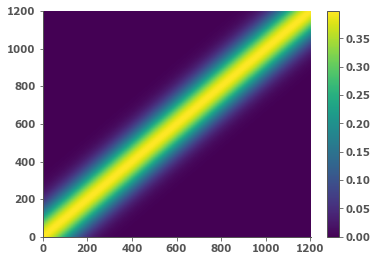

In [31]:
plt.pcolor(process_matrix)
plt.colorbar()
plt.show()

In [36]:
sps.norm(loc=0, scale=1).pdf([-1,-0.5,0,0.5,1])

array([0.24197072, 0.35206533, 0.39894228, 0.35206533, 0.24197072])

In [48]:
rt.highest_density_interval(posterior_distr.iloc[0].iloc[:,-1])

Low_90        0.00
Best_Guess    0.91
High_90       2.13
dtype: float64

In [ ]:
pd.Time